In [1]:
# ========
# imports
# ========
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from joblib import dump, load

In [2]:
# =================================================
# Loading & Concatenating Shadow Model Predictions
# (for training the attack model)
# =================================================
numShadowModels = 3

# read each CSV and stack them vertically into a single DataFrame
frames = []
for i in range(numShadowModels):
    df = pd.read_csv(f"shadow{i+1}_test_predictions.csv")
    frames.append(df)

attack_df = pd.concat(frames, ignore_index=True)

In [5]:
# ==========================================
# Preparing X (Features) & Y (Ground Truth)
# ==========================================
X = attack_df[["Predicted Label", "Confidence"]]
y = attack_df["True Label"]

# Sanity check
print(f"Shadow-train X shape: {X.shape}, y shape: {y.shape}")

Shadow-train X shape: (8000, 2), y shape: (8000,)


In [7]:
# ======================================
# Splitting into training and test sets
# ======================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


X_train: (6400, 2), X_test: (1600, 2)
y_train: (6400,), y_test: (1600,)


In [9]:
# ===============================
# Building the modeling pipeline
# ===============================
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

In [11]:
# =========================================
# Training and Evaluating the attack model 
# =========================================
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Attack on shadow-models (hold-out) results:\n")
print(classification_report(y_test, y_pred))

Attack on shadow-models (hold-out) results:

              precision    recall  f1-score   support

         0.0       0.79      0.77      0.78       798
         1.0       0.78      0.80      0.79       802

    accuracy                           0.79      1600
   macro avg       0.79      0.79      0.79      1600
weighted avg       0.79      0.79      0.79      1600



Shadow ROC AUC: 0.869


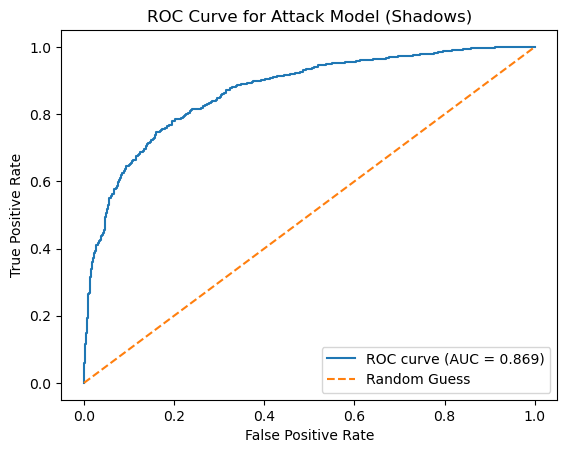

In [13]:
# =========================================
# ROC Curve and AUC Score on shadow-data
# =========================================
y_prob = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

print(f"Shadow ROC AUC: {roc_auc:.3f}")

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Attack Model (Shadows)')
plt.legend()
plt.show()

In [15]:
# =================================
# Save the trained attack pipeline
# =================================
dump(pipeline, "attack_pipeline.joblib")
print("Saved attack pipeline to attack_pipeline.joblib\n")

Saved attack pipeline to attack_pipeline.joblib



In [17]:
# ====================================================
# Evaluate the same attack model on TARGET embeddings
# ====================================================
# 1) Load target embeddings
x1_target_test  = np.load("x1_target_test.npy")   # non-members
x2_target_test  = np.load("x2_target_test.npy")
x1_target_train = np.load("x1_target_train.npy")  # members
x2_target_train = np.load("x2_target_train.npy")

In [19]:
# =======================================
# Sample 30% of the train-set as members
# =======================================
rng       = np.random.RandomState(42)
n_train   = x1_target_train.shape[0]
idx_train = rng.choice(n_train, size=int(0.3 * n_train), replace=False)

x1_train_s = x1_target_train[idx_train]
x2_train_s = x2_target_train[idx_train]

In [21]:
# ======================================
# Stack test + sampled-train embeddings
# ======================================
x1_attack = np.vstack([x1_target_test,  x1_train_s])
x2_attack = np.vstack([x2_target_test,  x2_train_s])
y_attack  = np.array([0] * len(x1_target_test) + [1] * len(x1_train_s))


In [23]:
# =======================================================
# Load your 3 shadow encoders, MLP heads, and thresholds
# =======================================================
encoders   = [load_model(f"shadow_encoder_{i+1}.h5")   for i in range(numShadowModels)]
mlps       = [load_model(f"shadow_mlp_{i+1}.h5")       for i in range(numShadowModels)]
thresholds = [np.load(f"shadow_threshold_{i+1}.npy")[0] for i in range(numShadowModels)]

In [25]:
# =======================================================
# Query each shadow to get (Predicted Label, Confidence)
# =======================================================
frames_tgt = []
for enc, mlp, thr in zip(encoders, mlps, thresholds):
    z1   = enc.predict(x1_attack)
    z2   = enc.predict(x2_attack)
    diff = np.abs(z1 - z2)               # or L2 norm if that’s what you used
    conf = mlp.predict(diff).flatten()   # your head’s probability output
    pred = (conf >= thr).astype(int)
    frames_tgt.append(pd.DataFrame({
        "Predicted Label": pred,
        "Confidence"     : conf
    }))

attack_tgt_df = pd.concat(frames_tgt, ignore_index=True)
attack_tgt_df["True Label"] = np.tile(y_attack, numShadowModels)

550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step


In [27]:
# ==============================================
# Prepare Features & Labels for the TARGET data
# ==============================================
X_target = attack_tgt_df[["Predicted Label", "Confidence"]]
y_target = attack_tgt_df["True Label"]

In [29]:
# ========================================
# Use the trained attack model to predict
# ========================================
y_pred_t = pipeline.predict(X_target)
print("\nAttack on target data results:\n")
print(classification_report(y_target, y_pred_t))


Attack on target data results:

              precision    recall  f1-score   support

           0       0.45      0.48      0.47     24000
           1       0.54      0.51      0.53     28800

    accuracy                           0.50     52800
   macro avg       0.50      0.50      0.50     52800
weighted avg       0.50      0.50      0.50     52800



Target ROC AUC: 0.501


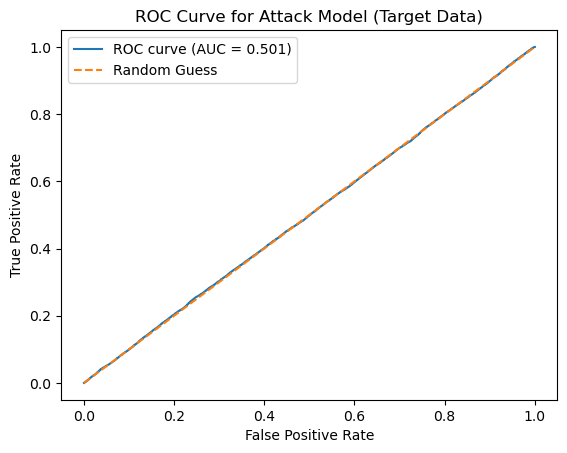

In [31]:
# =======================================
# ROC Curve and AUC Score on target data
# =======================================
y_prob_t = pipeline.predict_proba(X_target)[:, 1]
fpr_t, tpr_t, _ = roc_curve(y_target, y_prob_t)
roc_auc_t = auc(fpr_t, tpr_t)

print(f"Target ROC AUC: {roc_auc_t:.3f}")

plt.figure()
plt.plot(fpr_t, tpr_t, label=f'ROC curve (AUC = {roc_auc_t:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Attack Model (Target Data)')
plt.legend()
plt.show()